# Machine Learning - Practical 6

Names: {YOUR NAMES}

In [1]:
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import random
sns.set(context='talk',style='white',palette='colorblind')

## Task 0: Load data

To explore different clustering algorithms, we generated a toy dataset that consists of 5000 data points from a two dimensional mixture of Gaussian model with seven clusters.
Plot the data points with different colors for each cluster and indicated the cluster means.

In [2]:
# load data
with open('data_gmms.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [22]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (n_samples, n_features)-shaped array of data
        cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_clusters, n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''

    # ---------------- INSERT CODE ----------------------
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=10)
    for i,mean in enumerate(means):
        plt.scatter(mean[0], mean[1], label=f"Mean of Cluster #{i+1}")
    plt.legend()
    plt.show()
    
    
    # ---------------- END CODE -------------------------

In [23]:
toy_data = dataset['data']
toy_cluster_ids_true = dataset['labels']
toy_means = dataset['means']

In [24]:
print(toy_cluster_ids_true)

[0. 0. 0. ... 6. 6. 6.]


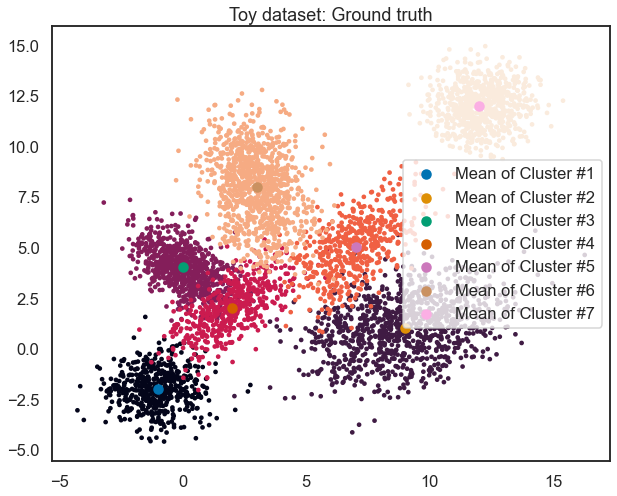

In [25]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

## Task 1: Cluster the data using k-Means

First, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 3, 5, 7, 10 and 20.

In [26]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters.
        input:
            data: (n_samples, n_features)-shaped array of data
            number of clusters: int, number of clusters
        output:
            kmeans_result: (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
    '''

    # ---------------- INSERT CODE ----------------------

    clusterer = KMeans(n_clusters)
    labels = clusterer.fit_predict(data)
    means = clusterer.cluster_centers_
    kmeans_result = (labels, means)
    
    
    # ---------------- END CODE -------------------------
    return kmeans_result

In [27]:
# run kmeans with different numbers of clusters

# ---------------- INSERT CODE ----------------------
cluster_ns = [3,5,7,10,20]
kmeans_labels = []
kmeans_means = []
for n in cluster_ns:
   labels, means  = run_KMeans(toy_data, n)
   kmeans_labels.append(labels)
   kmeans_means.append(means) 


# ---------------- END CODE -------------------------

Plot your results as cluster labels using the "plot_clustering" function and compare it to the original cluster labels. Describe your results.

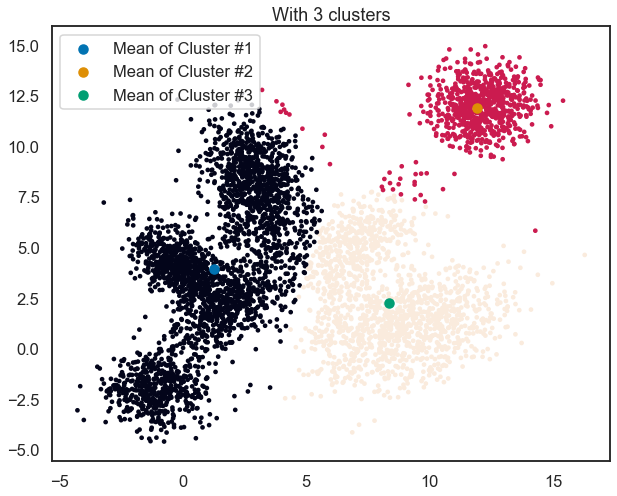

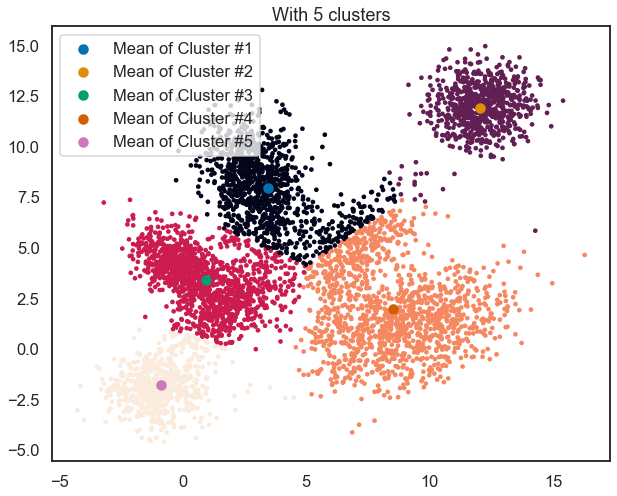

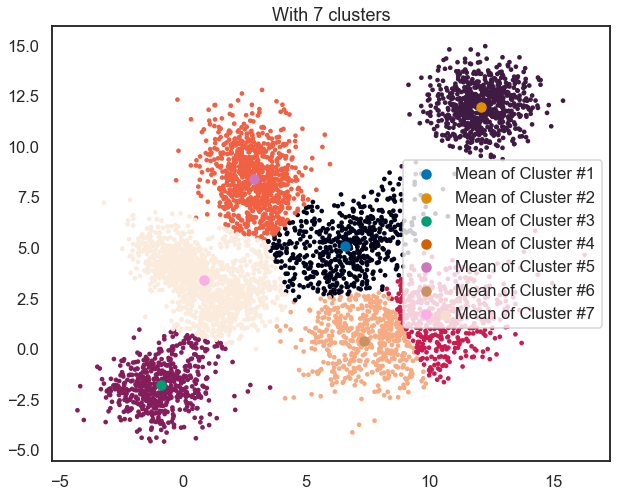

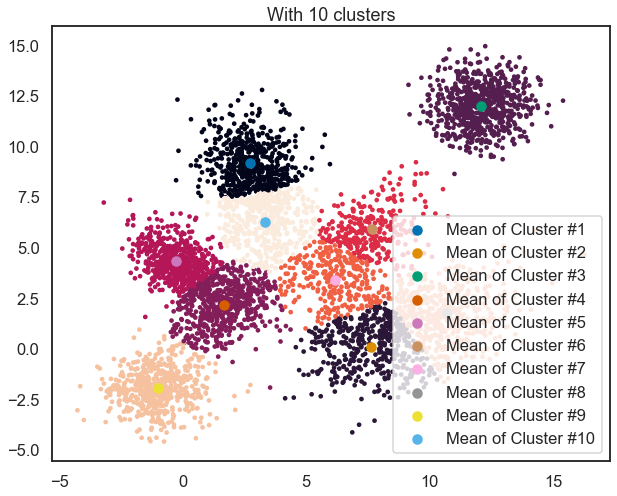

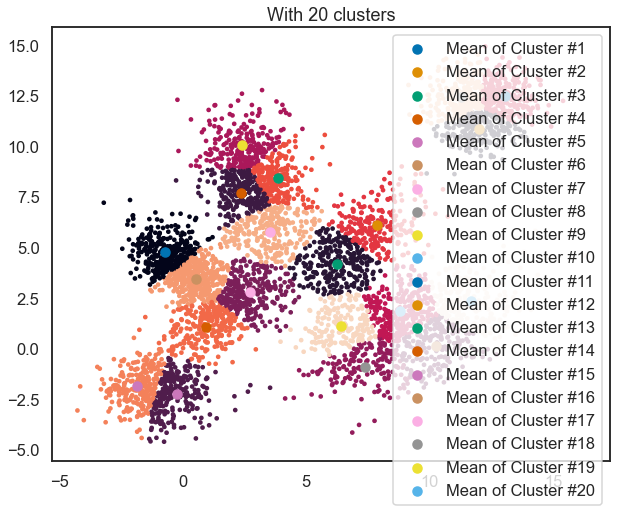

In [28]:
# plot results
# ---------------- INSERT CODE ----------------------
for i,n in enumerate(cluster_ns):
   plot_clustering(toy_data, kmeans_labels[i], kmeans_means[i], f"With {n} clusters")
# ---------------- END CODE -------------------------

YOUR ANSWER HERE

##  Task 2: Clustering using Gaussian Mixture Models

Next, we will implement clustering with Gaussian Mixture models as discussed in the Bishop in Chapter 9.2.2 pg. 435-439.

Implement the EM algorithm to fit a Gaussian mixture model on the data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

In [10]:
from IPython.display import clear_output

In [11]:
def gaussian(x, mu,sigma):
   """
   Multidimensional Gaussian

   inputs: 
      x -- datapoint, array with length k
      mu -- mean (k,) shaped array
      sigma -- covarianz matrix (k,k)

   returns:
   probability of x given mu and sigma
   """

   prefactor = 1/(np.sqrt((2*np.pi)**x.shape[0]*np.linalg.det(sigma)))
   return np.exp(1/2*(x-mu).T @ np.linalg.inv(sigma) @ (x-mu))*prefactor

In [54]:
def gmm(data, n_clusters, verbose=True, max_iter=1000, convergence_threshold=1e-4):
    '''Function that fits a mixture of gaussians to data.

        inputs:
            data          -- (n_samples, n_features)-shaped array of data points
            n_clusters    -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
            convergence_threshold  -- stop algorithm if change in log-lieklihood is below the treshold

        outputs:
            cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_clusters, n_features)-shaped array of fit mean vectors
            covs        -- (n_features, n_features, n_clusters)-shaped array of fit covariance matrices
            priors      -- (n_clusters)-shaped arrays of fit priors / mixing coefficients
        '''

    # ---------------- INSERT CODE ----------------------
    random.seed(3)
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    ### INITIALIZATION ###

    priors= np.random.rand(n_clusters)
    priors /= np.sum(priors)

    #equally spreaded around in data (in our case between -5 and 15)) this realy sholdn be hard coded in here !!!
    
    means = np.random.rand( n_clusters,n_features)*(np.max(data)-np.min(data)) + np.min(data)

    epsilon = np.identity(n_features) * 1e-5
    covs =  np.zeros((n_features,n_features, n_clusters))
    for i in range(n_clusters):
        cov = np.cov(data, rowvar=False)
        #covs[:,:,i] = cov + cov.T + epsilon
        covs[:,:,i] = np.ones((n_features,n_features)) + np.identity(n_features)/0.1 + epsilon
        #print(covs[:,:,i])

    y_n_k = np.zeros((n_samples,n_clusters))
    

    # init for loop
    log_like = 1.
    normal_dist = np.zeros((n_samples,n_clusters))
    inner = np.zeros((n_samples,n_clusters))
    step = 0

    ### ALTERNATE BETWEEN E & M STEP ###
    while True:
        
        print("Means: ", means[0,:])
        print("Covs:", covs[:,:,0])
        if step == max_iter: break
        step += 1

        ### E-STEP calculating the responseibilities ###
        for i in range(n_clusters):
            normal_dist[:,i] = priors[i] * np.apply_along_axis(gaussian, 1, data, mu=means[i,:], sigma=covs[:,:,i])
        divider = np.sum(normal_dist, axis=1)
        for i in range(n_clusters):
            y_n_k[:,i] = normal_dist[:,i]/divider
        ### M-STEP calculating optimal mean covarianz and priors ###
        N_k = np.sum(y_n_k, axis=0)
        for i in range(n_clusters):
            ynk = np.vstack([y_n_k[:,i],y_n_k[:,i]]).T
            means[i,:] = 1/N_k[i] * np.sum( ynk * data, axis=0)

            #covs[:,:,i] = 1/N_k[i] * np.cov(data * ynk, rowvar=False)+epsilon
            covs[:,:,i] = 1/N_k[i] * np.cov(data, aweights=y_n_k[:,i], rowvar=False)+epsilon

            priors[i] = N_k[i]/np.sum(N_k)
        ### CHECK FOR CONVERGENCE/ PRINT LOG_LIKELIHOOD if VERBOSE ###
        for i in range(n_clusters):
            normal_dist[:,i] = np.apply_along_axis(gaussian, 1, data, mu=means[i,:], sigma=covs[:,:,i])
            inner[:,i] = (priors[i] * normal_dist[:,i])
        log_like = np.sum(np.log(np.sum(inner, axis=1)))
        if verbose:
           # clear_output()
            print(f"Step: {step} ,act log like: ", log_like)
        if log_like<=convergence_threshold:
            print("Converged")
            return y_n_k, means, covs, priors
        if log_like == np.nan: 
            print(f"Log likeleyhood couldnt be calculated. stopped after {step} steps")
            return y_n_k, means, covs, priors

    ### ASSIGN CLUSTER LABELS ###


    # ---------------- END CODE -------------------------
    return y_n_k, means, covs, priors
    #return (cluster_ids, means, covs, priors)



In [55]:
print(toy_means)

[[-1 -2]
 [ 9  1]
 [ 0  4]
 [ 2  2]
 [ 7  5]
 [ 3  8]
 [12 12]]


In [56]:
gmm(toy_data,7)

Means:  [3.79330004 1.15535948]
Covs: [[11.00001  1.     ]
 [ 1.      11.00001]]


/var/folders/m7/k82fqv6524xf0hm4dfd2fj8h0000gn/T/ipykernel_26330/156719349.py:15: RuntimeWarning: overflow encountered in exp
  return np.exp(1/2*(x-mu).T @ np.linalg.inv(sigma) @ (x-mu))*prefactor
/var/folders/m7/k82fqv6524xf0hm4dfd2fj8h0000gn/T/ipykernel_26330/156719349.py:15: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(1/2*(x-mu).T @ np.linalg.inv(sigma) @ (x-mu))*prefactor


Step: 1 ,act log like:  inf
Means:  [10.95509409  9.10026363]
Covs: [[0.1570068  0.15657015]
 [0.15657015 0.44999607]]


/var/folders/m7/k82fqv6524xf0hm4dfd2fj8h0000gn/T/ipykernel_26330/2384054370.py:62: RuntimeWarning: invalid value encountered in true_divide
  y_n_k[:,i] = normal_dist[:,i]/divider


Step: 2 ,act log like:  nan
Means:  [nan nan]
Covs: [[nan nan]
 [nan nan]]
Step: 3 ,act log like:  nan
Means:  [nan nan]
Covs: [[nan nan]
 [nan nan]]


KeyboardInterrupt: 

Explore the results of GMM using different numbers of clusters and initialization strategies.

Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? How does it compare to the k-Means solution? Plot ground truth, k-Means and GMM cluster assignment side-by-side to compare them.

If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

In [ ]:
# plotting


YOUR ANSWER HERE